# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 1: Introduction to Web Scraping

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
**Lab Authors**: Chris Gumb and Eleni Kaxiras

<hr style='height:2px'>

## Lab Learning Objectives

When we're done today, you will approach messy, real-world data on the we with the confidence that you can get it into a format that you can use to answer your questions of interest.

Specifically, our learning objectives are:
* Pulling HTML content from the web programmatically with [Requests](https://requests.readthedocs.io/en/latest/)
* Navigating the tree-like structure of an HTML document and using that structure to extract desired information with the help of [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* Wrangling, parsing, and storing information pulled from the web using regular expressions, lists, and dictionaries.
* Creating a tabular data object (Pandas DataFrame) from parsed data and saving it as a comma separated values file (csv)


In [0]:
# Importing necessary libraries
import matplotlib.pyplot as plt # plotting library
import pandas as pd # tabular data (Dataframes)
from bs4 import BeautifulSoup # HTML parsing
import requests # get/post HTML requests
import json # key-value data structure
from IPython.display import HTML # render HTML in the notebook
import html # for converting escaped characters in HTML content

## Starting with Questions

In this lab we'll try and learn something about the Nobel Prize.
Inquiry starts by asking some specific questions. For example:

* 1) Has anyone won a prize more than once?
* 2) How has the total number of prizes award changed over time?
* 3) How has the number of recipients per award changed over time?

To attempt to answer any of these questions, we'll need **data**: *who* received *what* award and *when*. 

## When possible: find a structured dataset! (.csv, .json, .xls)

After some quick googling, we stumble upon this [dataset on github](https://github.com/OpenRefine/OpenRefine/blob/master/main/tests/data/nobel-prize-winners.csv). We've provided you with a local copy in `data/github-nobel-prize-winners.csv`.

We'll use **Pandas** to read the data into a table called a `DataFrame`. Don't worry about the syntax here. We'll cover Pandas in-depth next week!

In [0]:
# read the csv file into a Pandas Dataframe object
df = pd.read_csv("data/github-nobel-prize-winners.csv")
# unescape HTML chars in 'winner' column
df['winner'] = df[['winner']].applymap(html.unescape)
# display the top few rows (default is 5)
df.head() 

But we don't know Pandas yet!! So let's simplify things and just take all the names in the `winner` column and put them in a list; we know how to work with those!

In the command below, we first take the Dataframe and extract the `winner` column, which is a Pandas data type called a `Series` object.  Then, from the series, we extract the values, which are a Numpy `ndarray`. Finally, we convert this array into a regular old Python list. Phew! Don't stress about these steps. Like we said, we'll cover Pandas next week. 

In [0]:
winners = list(df.winner.values)
winners

### Question: Did anyone recieve the Nobel Prize more than once?

**How would you check if anyone recieved more than one nobel prize?**

We can use a list comprehension with a conditional statement using the list method `count()` to find all winners who occur more than once in a list.

In [0]:
[w for w in winners if winners.count(w) > 1]

We can also exlude the "No Prize was Awarded" entries and sort the list.

In [0]:
sorted([w for w in winners if (winners.count(w) > 1) and not w.startswith("No Prize")])

And finally, let's make it a **set** instead of a list so we only see the unique values.

In [0]:
{w for w in winners if (winners.count(w) > 1) and not w.startswith("No Prize")}

All questions, such as "did anyone receive the Noble Price more than once?" are easy to answer when the data is present in such a clean tabular form. However, more often than not, *we won't find the data we need in such a nice format!* 

In such cases, we need to perform **web scraping** and cleaning to get the data we desire. The end result of this lab is to create a Pandas dataframe similar to the one above by means of a little web scraping and cleaning.

# WEB SCRAPING


#### The first step in web scraping is to understand the HTML structure of the webpage.

#### But, what is HTML?

HTML (**H**yper **T**ext **M**arkup **L**anguage), is the standard markup language for documents designed to be displayed in a web browser. It is often complemented by CSS for styling and JavaScript for dynamic, interactive content.

HTML describes the structure of a web page *semantically*. That is, describes not only the position of each element in the document's tree structure (e.g., 2nd child of tree's root), but also what each element *means* (title, level 2 header, paragraph, etc.).

### Standard HTML documents

HTML documents generally have the following structure:

\<!DOCTYPE html>

<html>

    <head>

        <title>Page Title</title>

    </head>

    <body>

        <h1>Page Heading</h1>

        <p>The first paragraph of page</p>

        ...
        ...
        ...

    </body>

\</html>

### What does each of these tags indicate?

- The **\<!DOCTYPE html>** declaration defines that this document is an HTML5 document

- The **\<html>** element is the root element of an HTML page

- The **\<head>** element contains meta information about the HTML page

- The **\<title>** element specifies a title for the HTML page (which is shown in the browser's title bar or in the page's tab)

- The **\<body>** element defines the document's body, and is a container for all the visible contents, such as headings, paragraphs, images, hyperlinks, tables, lists, etc.

- The **\<h1>** element defines a large heading. There are other heading tags in html, **\<h2>, \<h3>, \<h4>, \<h5>, \<h6>**

- The **\<p>** element defines a paragraph


### What is an HTML Element?

An HTML element is defined by a start tag, some content, and an end tag:

**\<tagname> Tag content \</tagname>**

An example of an HTML element is as follows:

**\<h1> The Page Heading \</h1>**



### WEB SCRAPING


The official <a href = https://www.nobelprize.org/prizes/lists/all-nobel-prizes/> Nobel website </a> has the data we want, but in 2018 and 2019 the physics prize was awarded to multiple groups so we will use an archived version of the web-page for an easier introduction to web scraping.


[The Internet Archive](https://archive.org/) periodically crawls most of the Internet and saves what it finds. (That's a lot of data!) So let's grab the data from the Archive's "Wayback Machine" (great name!). We've just given you the direct URL, but at the very end you'll see how we can get it out of a JSON response from the Wayback Machine API.


Let's take a look at the [2018 version of the Nobel website](http://web.archive.org/web/20180820111639/https://www.nobelprize.org/prizes/lists/all-nobel-prizes/) and to look at the HTML under-the-hood: right-click and click on `inspect`.You should see something like this.

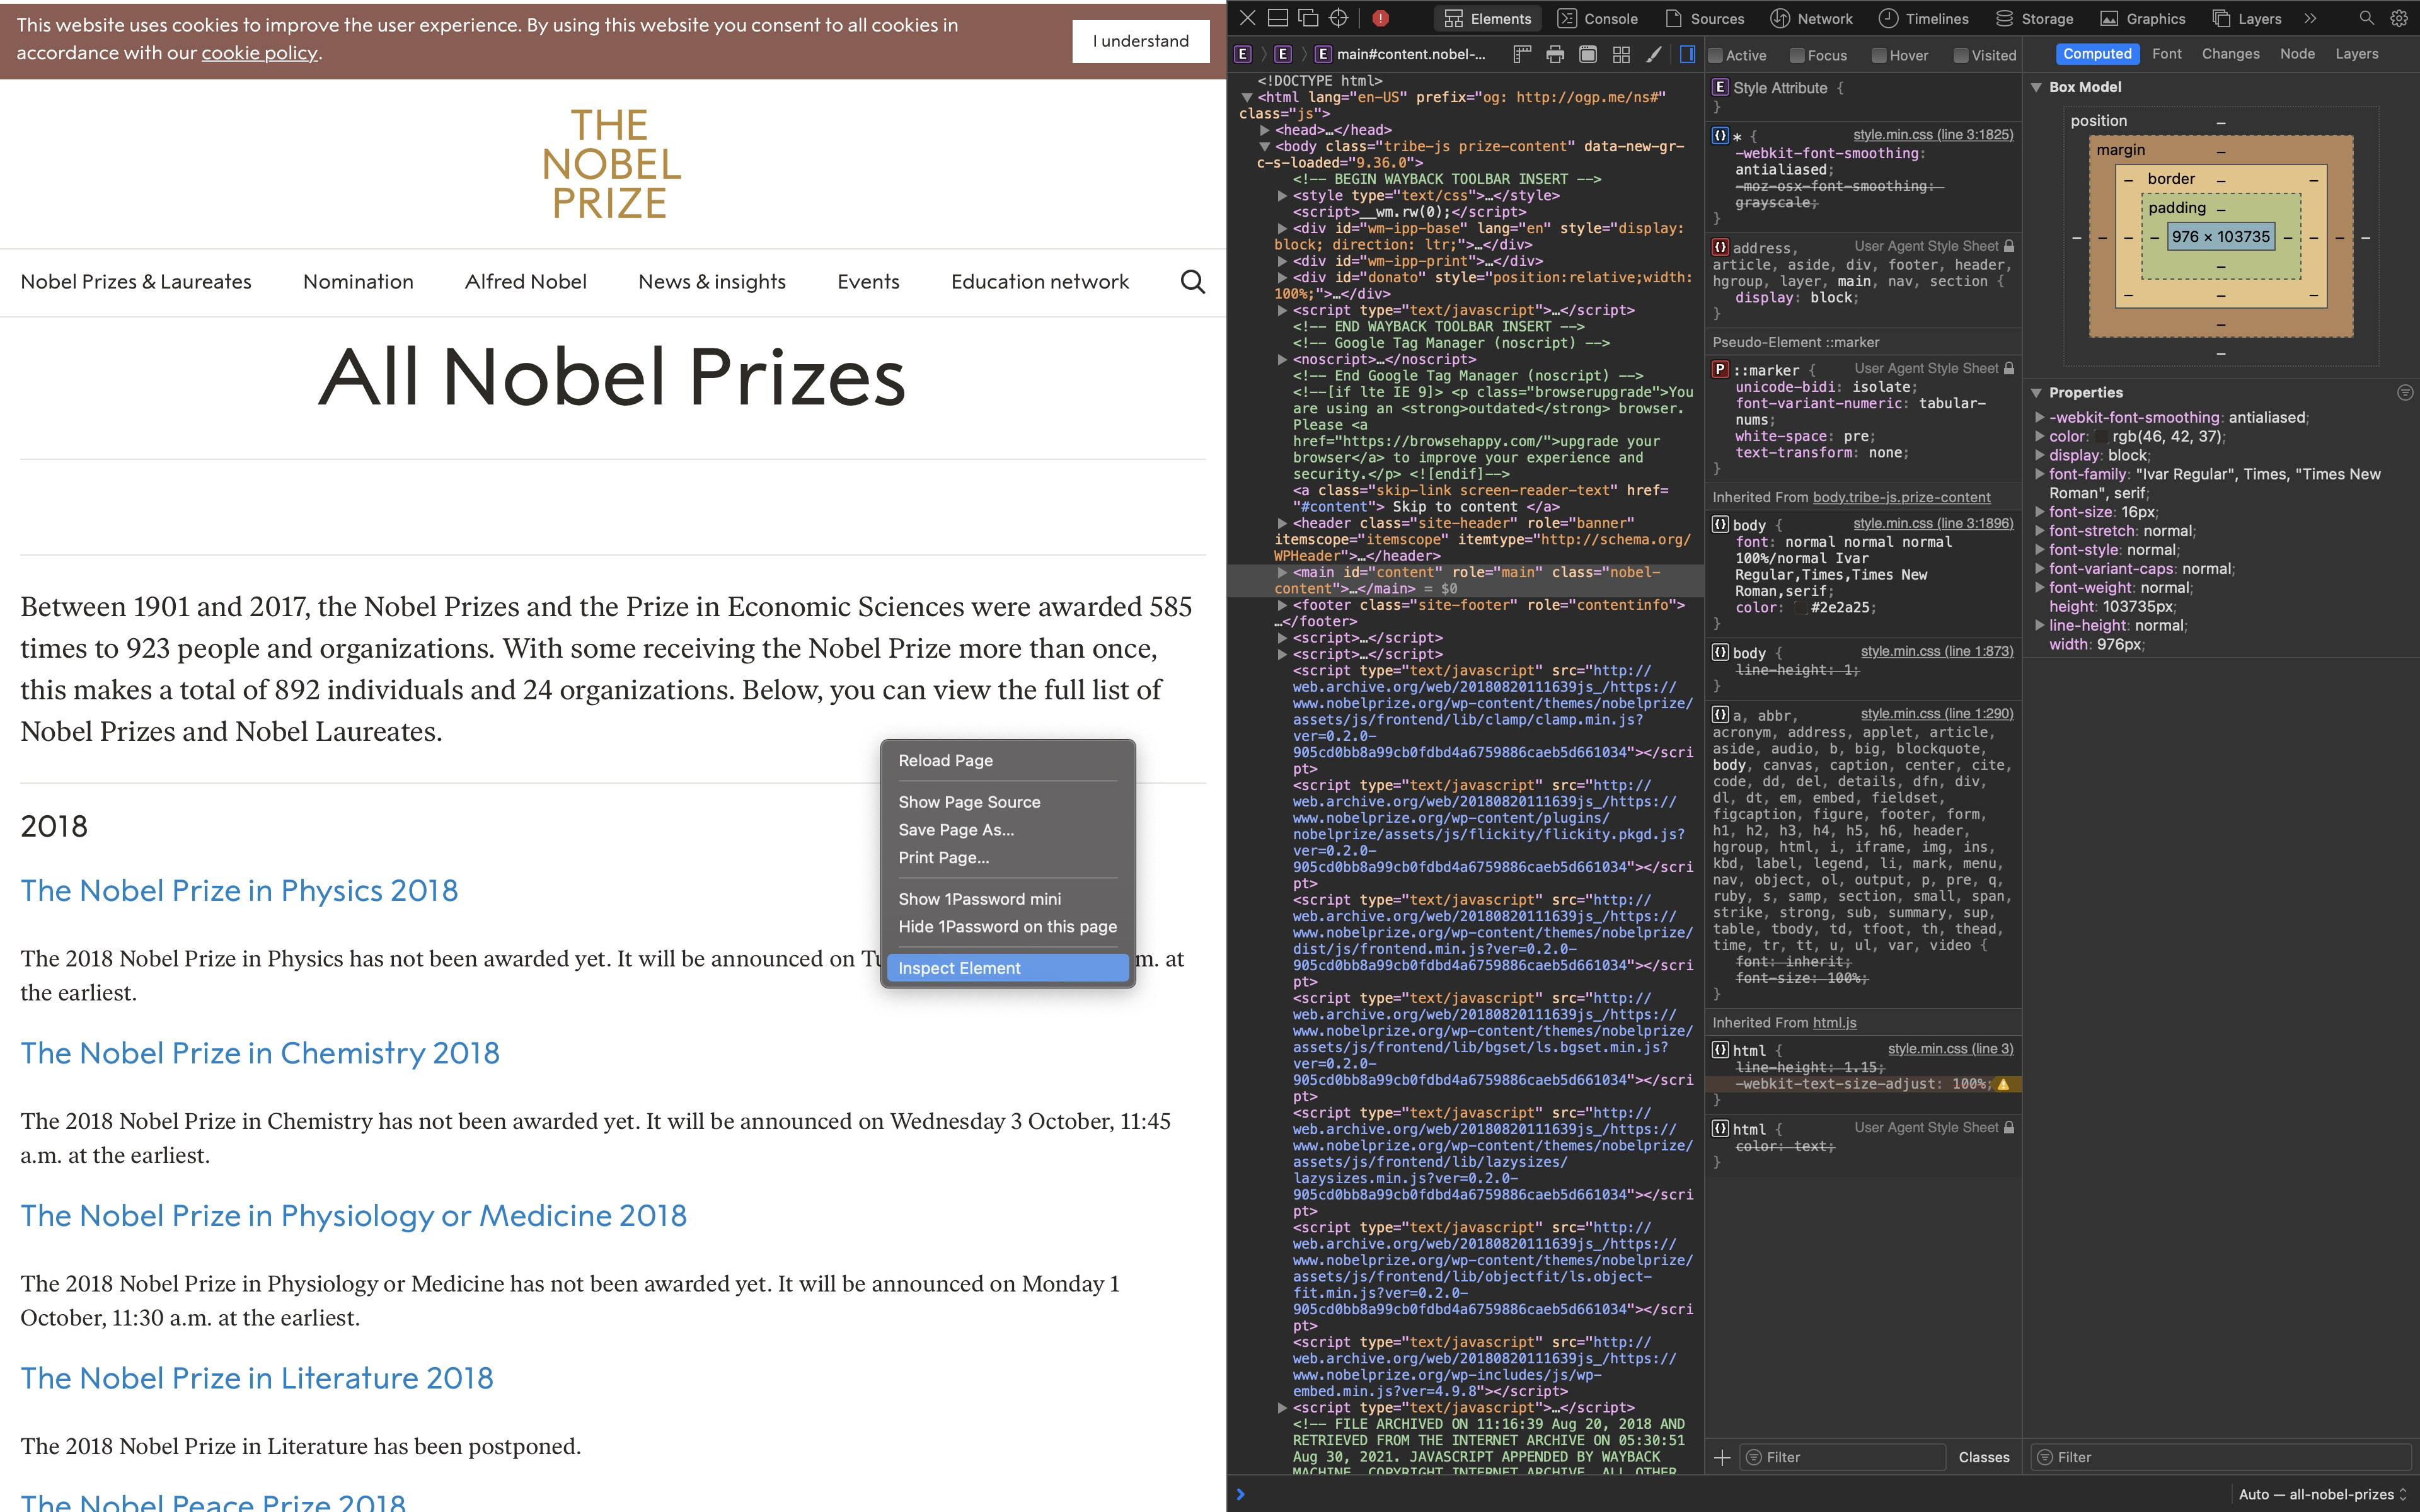

### Mapping the HTML tags to the webpage

When you inspect, try to map each element on the webpage to its HTML. 

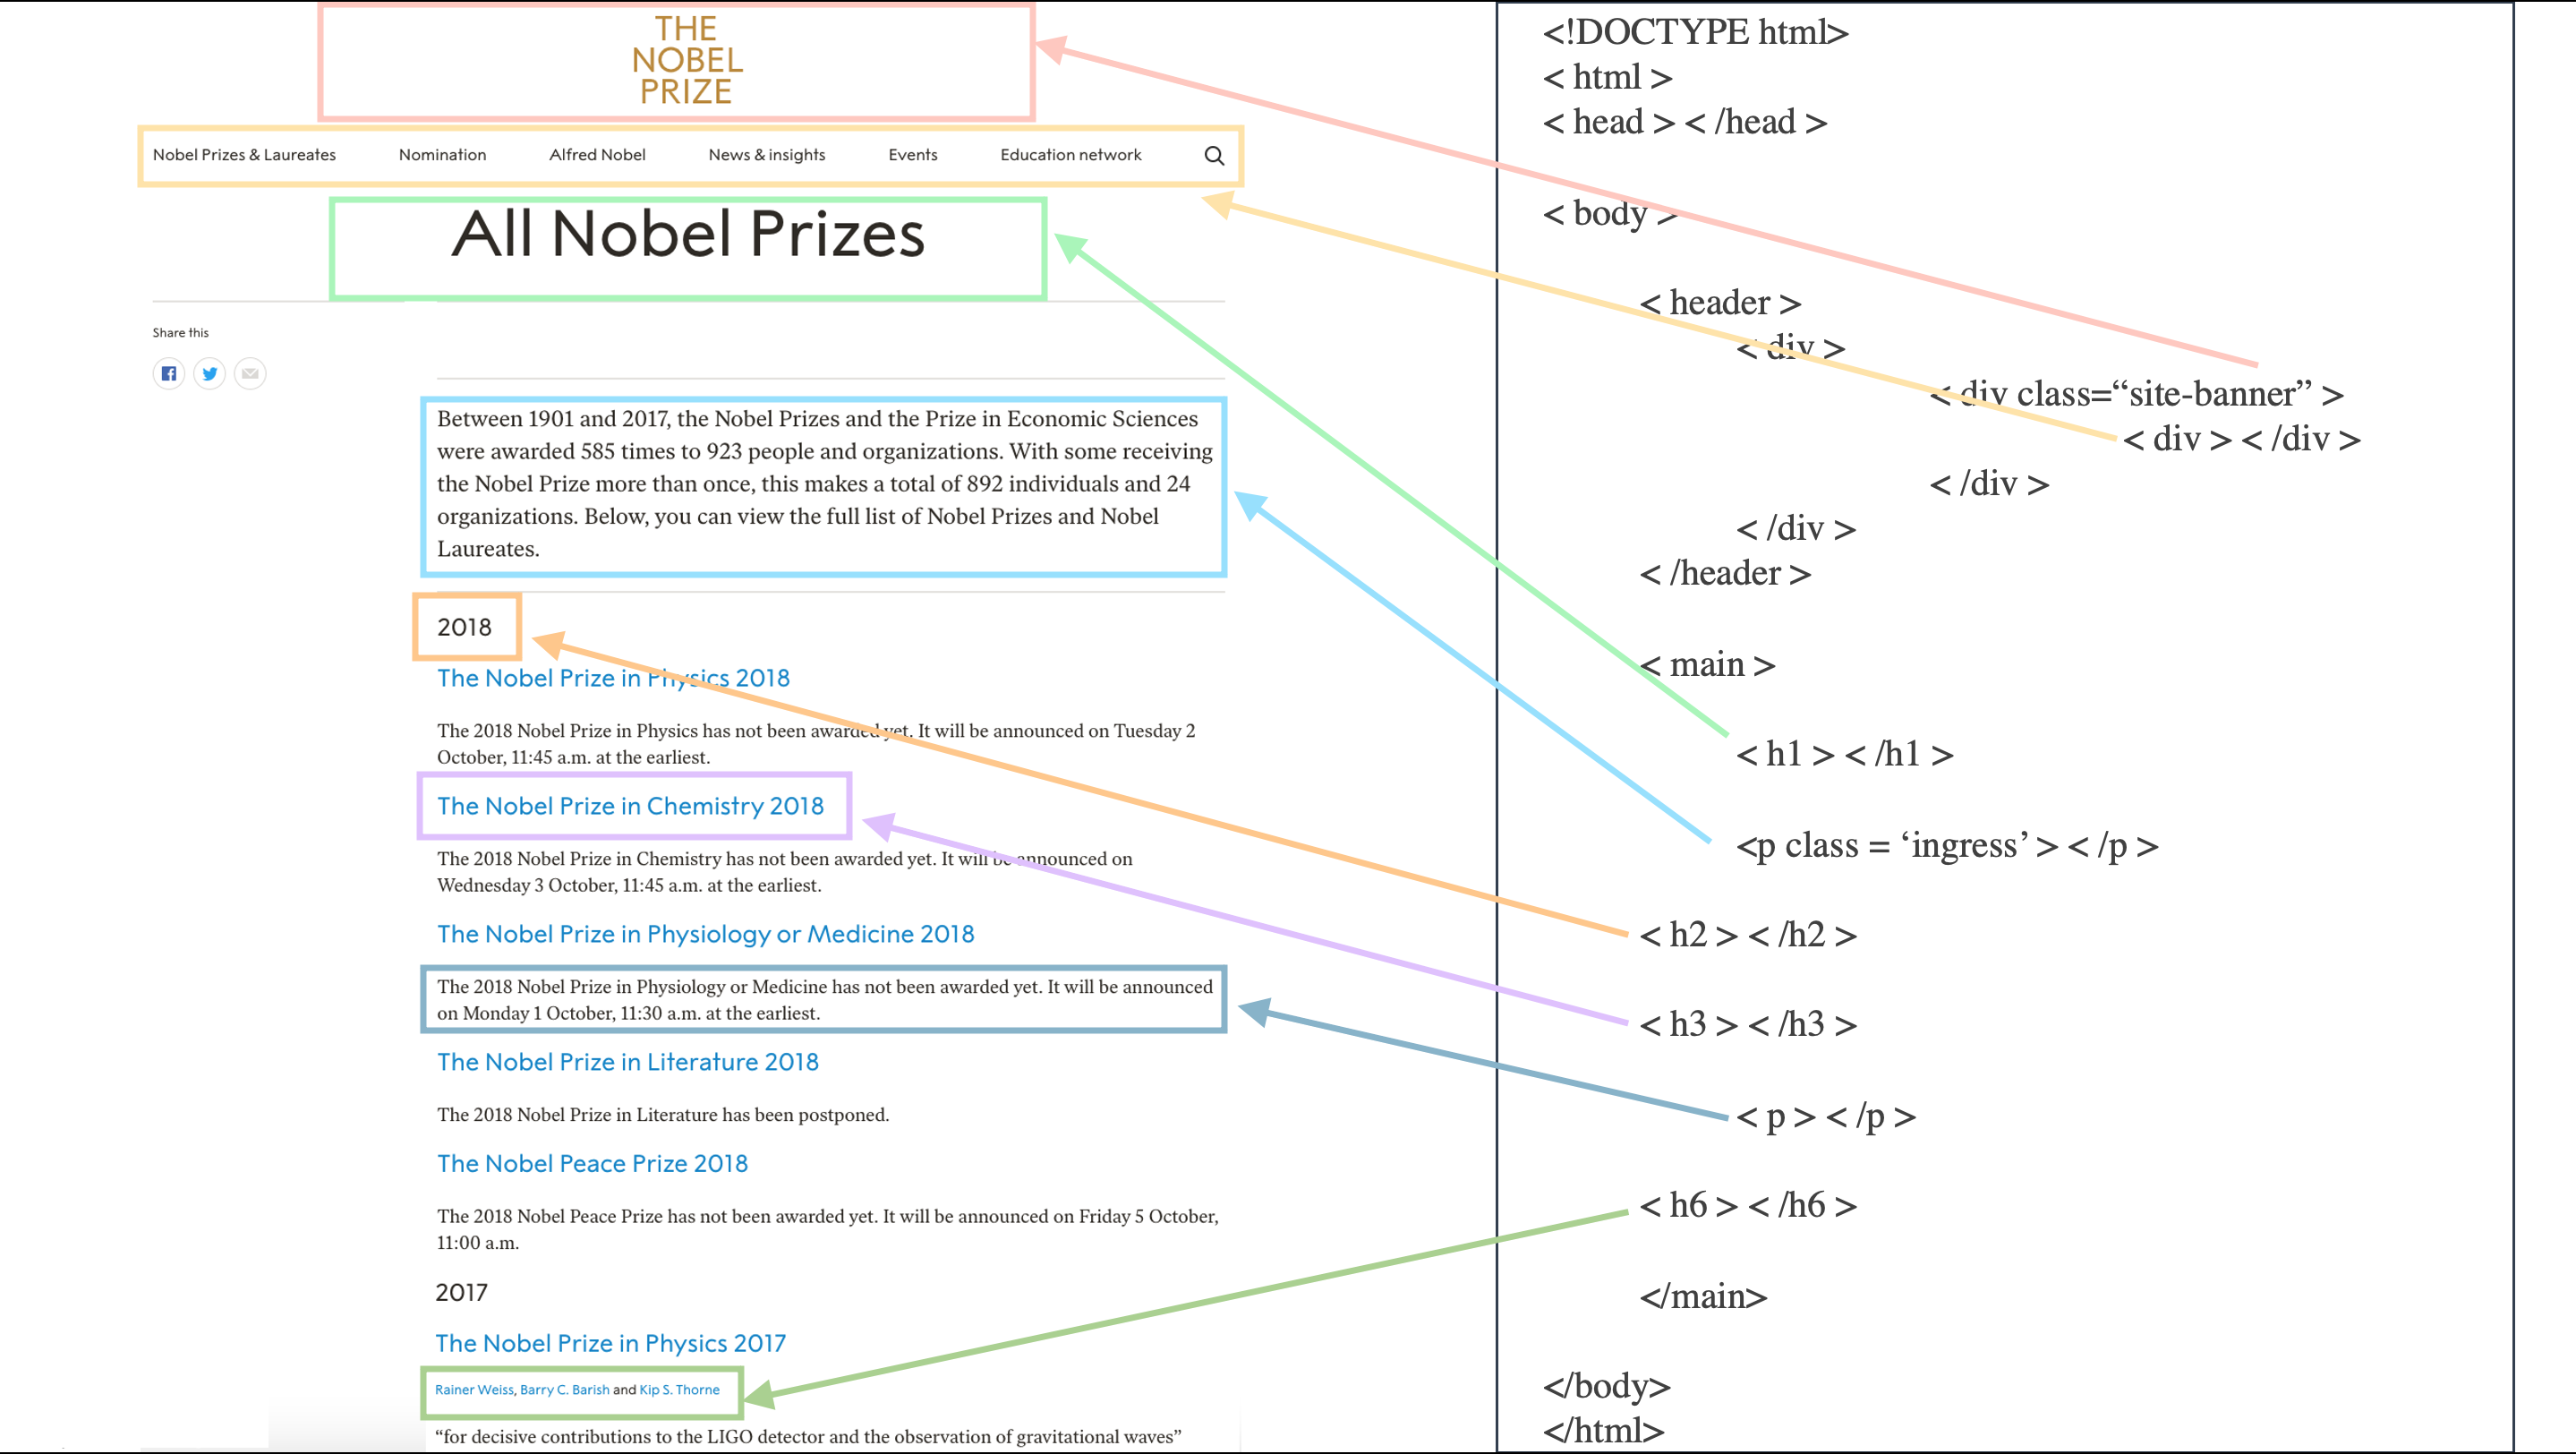

In [0]:
# here is what we will get after selecting using the class by year tag.

einstein = HTML('\
         <div class ="Class: by year">  \
             <h3> \
                 <a href="http://web.archive.org/web/20180820111639/https://www.nobelprize.org/nobel_prizes/physics/laureates/1921/"> \
                        The Nobel Prize in Physics 1921 \
                  </a> \
             </h3> \
             <h6> \
                 <a href="http://web.archive.org/web/20180820111639/https://www.nobelprize.org/nobel_prizes/physics/laureates/1921/einstein-facts.html">\
                        Albert Einstein</a> \
             </h6> \
             <p> \
                 “for his services to Theoretical Physics, and especially for his discovery of the law of the photoelectric effect” \
             </p> \
        ')
display(einstein)

## Getting HTML from the Web

If our end goal is to extract data from HTML documents or first step is to acquire those HTML files from the web.\
We could of course visit a web page in our browser and save the page to disk. But that sort of tedious clicking is what we use programming to avoid!\
There are command line applications like [curl](https://curl.se/) which can be used to pull web data, and options like this can be worked into larger scripts or programming procects. But we're looking for something a bit more... Pythonic.

## Requests

"[Requests](https://requests.readthedocs.io/en/latest/) is an elegant and simple [HTTP](https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol) library for Python, built for human beings."

Its ease of use has made this 3rd party library a very popular option for pulling content from the web via the HTTP `GET` request. This is the request your browser sends to the webserver to view a webpage.

First, we'll need the target URL.

In [0]:
snapshot_url = 'http://web.archive.org/web/20180820111639/https://www.nobelprize.org/prizes/lists/all-nobel-prizes/'

Then we use the `get` method to grab the content of that URL.\
The returned object is a `Response` which has some useful information beyond the website content. For example, the response status code.

In [0]:
snapshot = requests.get(snapshot_url)
type(snapshot)

In [0]:
snapshot.status_code

Response [200] is a success status code. Let's google: [`response 200 meaning`](https://www.google.com/search?q=response+200+meaning&oq=response+%5B200%5D+m&aqs=chrome.1.69i57j0l5.6184j0j7&sourceid=chrome&ie=UTF-8). All possible codes and their meanings can be found [here](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status).

Try to request "www.xoogle.be". What happens?

In [0]:
bogus_url = 'http://web.archive.org/web/20180820111639/https://www.xoogle.be'
bogus_response = requests.get(bogus_url)
bogus_response.status_code

The dreaded "404 NOT FOUND" error! ☠️\
(JupyterHub users may see 403)

**😇 A Brief Aside About Ethical Scraping:**

We should always remember to “not to be evil” when scraping with requests or any other tool! When downloading multiple pages (like you will do in HW1), always put a small delay between requests (e.g, `time.sleep(1)`, with the `time` library) so you don’t unwittingly hammer someone’s webserver and/or get blocked.

**HTML Content**

Now let's look at the content we just scraped which is contained in the `text` attribute of our original Request object which we called `snapshot`.

In [0]:
raw_html = snapshot.text
print(raw_html[:5000])

We now that we have the page's HTML data in a Python string, how should we go about parsing and navigating all this text to find what we are interested in?

## Regular Expressions

You can find specific patterns or strings in text by using Regular Expressions (often abbreviated "re", "regex", or "regexp"): This is a pattern matching mechanism used throughout Computer Science and programming (it's not just specific to Python). 

Some great resources that we recommend, if you are interested in them (could be very useful for a homework problem):
- https://docs.python.org/3/howto/regex.html 
- https://regexone.com (tutorial)
- https://regex101.com (testing patters)

Regular expressions use specific characters to stand for sets of characters or modifiers. A regex itself defines a set of strings which we call "matches."\
Some examples: 
- ```\s``` : Matches any Unicode whitespace character: spaces, tabs, newlines
- ```\S``` : Matches any character which is **NOT** a Unicode whitespace character (note: capital 'S')
- ```\d``` : Matches any Unicode decimal digit, `0`, `1`, ..., `9`
- ```\w``` : Matches any "word" characters: letters, numbers, and underscores
- ```*``` : Causes the resulting RE to match 0 or more repetitions of the preceding RE, as many repetitions as are possible.
- ```+``` : Similar to `*` but matches 1 or more prepitions of prededing RE 
- ```{n}```: Matches `n` occurances of the preceding RE. Ex: `b{3}` would match `'bbb'`

Python includes [re](https://docs.python.org/3.10/library/re.html) in its standard library. We can use its `find_all` method to find all substrings in a target string that match a regular expression of our devising. 

**Let's find all the occurances of 'Marie' in our raw_html:**

In [0]:
import re

In [0]:
re.findall(r'Marie', raw_html)

**Now use ```\S``` to match 'Marie' + ' ' + 'any character which is not a Unicode whitespace character':**

In [0]:
re.findall(r'Marie \S',raw_html)

**How would we find the lastnames that come after Marie?**

ANSWER: The \w character represents any alpha-numeric character. \w* is greedy and gets a repeat of the characters until the next bit of whitespace.

In [0]:
# your code here

This is an example of code that is *intended* to grab the first title, which is the text content of an anchor (link) tag which is itself contained inside of an h3 header. 

In [0]:
first_title = re.findall(r'<h3><a.*>.*<\/a><\/h3>', raw_html)[0]
print(first_title)

It seems to work. But regex can quickly become complex, and while they can prove useful in many scenarios (like those in HW0!), it is ill-advised to use them to parse HTML tags. This is because regexs are not sufficiently complex to capture all possible HTML structures. If you're curious you can read about the distinctions between [Regular Grammars](https://en.wikipedia.org/wiki/Regular_grammar) (regex) and [Context-free Grammars](https://en.wikipedia.org/wiki/Context-free_grammar) (HTML).

## Parse the HTML with BeautifulSoup

"[BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/) is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree. It commonly saves programmers hours or days of work."

BeautifulSoup works by parsing the raw html text into a tree. Every tag in the raw html becomes a node in the tree. We can then navigate the tree by selecting a node and querying its parent, children, siblings, etc.

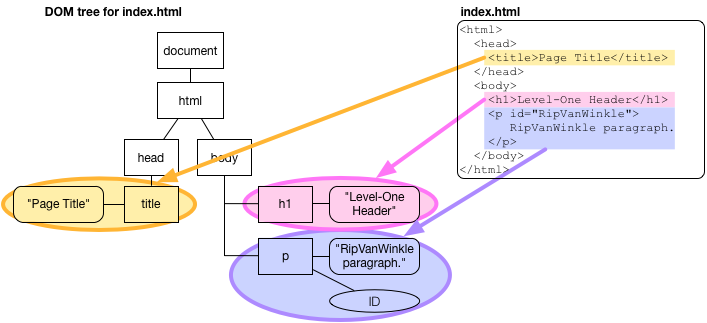

In [0]:
soup = BeautifulSoup(raw_html, 'html.parser')

Key BeautifulSoup functions we’ll be using in this lab:

**Visually Inspecting**
- **`tag.prettify()`**: Returns cleaned-up version of raw HTML, useful for printing

**Searching**
- **`tag.select(selector)`**: Return a list of nodes matching a [CSS selector](https://developer.mozilla.org/en-US/docs/Learn/CSS/Introduction_to_CSS/Simple_selectors)
- **`tag.select_one(selector)`**: Return the first node matching a CSS selector
- **`tag.text`/`soup.get_text()`**: Returns visible text of a node (e.g.,"`<p>Some text</p>`" -> "Some text")
- **`tag.contents`**: A list of the immediate children of this node

You can also use these functions to find nodes.
- **`tag.find_all(tag_name, attrs=attributes_dict)`**: Returns a list of matching nodes
- **`tag.find(tag_name, attrs=attributes_dict)`**: Returns first matching node

You are not limit to searching for tags. You can also search for text, even using regular expressions!:
- **`tag.find("div", string="Text of Interest")`**: Returns the first `div` tag who `text` content is "Text of Interest"
- **`tag.find("a", string=re.compile(r"\d+"))`**: Returns the first `a` tag who `text` content is one or more digits

Or you can move about the tree using relative position:

**Going Down**
- **`tag.children`**: Returns a list of tags directly below `tag` in the tree.
- **`tag.descendants`**: Returns a lost of *all* tags directly below `tag`. Like a recursive version of `tag.children`
**Going Up**
- **`tag.parent`**: Returns tag directly above `tag`
- **`tag.parents`**: Returns a list of recursive parents of `tag` all the way to the root of the tree

**Going Sideways**
- **`tag.next_sibling`**: Returns next tag with the same parent as `tag`
- **`tag.previous_sibling`**: Returns next tag with the same parent ass `tag`


BeautifulSoup is a very powerful library -- much more info here: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

### Let's practice some BeautifulSoup commands...

**Print a cleaned-up version of the raw HTML** Which function should we use from above?

In [0]:
pretty_soup = soup.prettify()
print(pretty_soup[:500])

**Extract the text of first “title” object** 

In [0]:
# your code here

Return the first 50 anchor tags (`<a ....></a>`) which are themselves contained inside of an `<h3>` header tag:

In [0]:
# your code here

## Extracting award data

Let's use the structure of the HTML document to extract the data we want.

From inspecting the page in our browser, we found that each award is in a `div` with a `by_year` class. Let's get all of them!

When using `select` we can prepend a '.' to a string and to specify that we are talking about the tag's class attribute, rather than the name of a type of tag.

In [0]:
award_nodes = soup.select('.by_year') # returns all tags with class="by year"
len(award_nodes)

Let's pull out an example.

In [0]:
award_node = award_nodes[109]

In [0]:
award_node

In [0]:
HTML(award_node.prettify())

#### Let's practice getting data out of a BS Node

### The prize title

In [0]:
award_node.select_one('h3').text

**How do we separate the year from the selected prize title?**

In [0]:
award_node.select_one('h3').text[-4:]

**How do we drop the year from the title?**

In [0]:
award_node.select_one('h3').text[:-4].strip()

Let's put them into functions:

In [0]:
def get_award_title(award_node):
    return award_node.select_one('h3').text[:-4].strip()

def get_award_year(award_node):
    return int(award_node.select_one('h3').text[-4:])

**Make a list of titles for all awards**

Recall that we have a list of `award_nodes` and a `get_award_title` function.

In [0]:
# your code here

**How can we make this into a one-liner?**

We can use a *list comprehension*: [f(x) for x in iterable]

List comprehensions are explained in the slides from us linked above.

In [0]:
# your code here

### The recipients
**How do we handle there being more than one?**

In [0]:
award_node.select('h6 a')

In [0]:
[node.text for node in award_node.select('h6 a')]

Let's encapsulate this process into a function.

In [0]:
def get_recipients(award_node):
    return [node.text for node in award_node.select('h6 a')]

We'll leave them as a list for now, to return to this later.

***This is how you would get the links: (Relevant for the HW1)***

In [0]:
[state_node.get("href") for state_node in award_node.select('h6 a')]

### The prize "motivation"

**How would you get the 'motivation'/reason of the prize from the following ```award_node```?**

In [0]:
award_node = award_nodes[42]
award_node

In [0]:
# your code here

Putting everything into functions, but be sure to handle the case where the `<p>` isn't found.

In [0]:
# your code here

## Let's create a Pandas dataframe

Next, we parse the collected data and create a `pandas.DataFrame`. A DataFrame is like a table, where each row corresponds to a data entry and each column corresponds to a feature. Once we have a DataFrame, we can easily export it to our disk in CSV, JSON, or other formats.

The easiest way to create a DataFrame is to build a list of dictionaries. Proficiency with Python dictionaries is a pre-requisite for this course. Refer to the slides from us [here](references/Dictionaries.pdf) for a better refersher.

Each entry (dict) in the list is a data point, where keys are column names in the table. Let's see it in action.

In [0]:
awards = []
for award_node in soup.select('.by_year'):
    # Initialize the dictionary
    award = {} #{key: value}
    
    award['title'] = get_award_title(award_node)
    award['year'] = get_award_year(award_node)
    award['recipients'] = get_recipients(award_node)
    award['num_recipients'] = len(award['recipients'])
    award['motivation'] = get_award_motivation(award_node)    
    awards.append(award)
awards[109:112]

We then pass the list of dictionaries to the DataFrame constructor.

In [0]:
df_awards = pd.DataFrame(awards)

In [0]:
df_awards

To export the data to a local CSV file, let's used the `.to_csv()` method. After you run the follwing code, you can find a `scraped_awards.csv` in the same directory with this notebook. You can open the notebook using Microsoft Excel or Numbers, but make sure you are using the UTF-8 codec.

### Visualizing Number of Recipients by Year

We are now in a position to visualize the total number of recipients each year. Don't worry about the syntax for the code below right now; you'll be a Pandas pro by the end of week 2!

In [0]:
# Group by year and sum up the number of recipients
agg_data = df_awards.groupby('year')['num_recipients'].sum()

# Plotting the aggregated data
fig, ax = plt.subplots(figsize=(12, 6))
agg_data.plot(kind='bar', width=0.8, color='lightgreen')

# Setting x-ticks for each decade
ax.set_xticks([tick for tick in range(len(agg_data)) if agg_data.index[tick] % 10 == 0])
ax.set_xticklabels([str(year) for year in agg_data.index if year % 10 == 0], rotation=0)

plt.title("Total Number of Nobel Prize Recipients by Year")
plt.ylabel("Number of Recipients")
plt.xlabel("Year");

Finally, we can write our DataFrame to a csv file. Compared to the other Nobel Prize csv we found on the internet, you might agree that ours is much more detailed and useful!

In [0]:
df_awards.to_csv('data/scraped_awards.csv')

## Bonus Challenge! (time permitting)

The Brattle Theatre is a non-profit movie theatre located in Harvard Square that has been showing films since 1953.

Let's see if we can use what we've learned above to create a DataFrame containing the following data from a past '[coming soon](https://web.archive.org/web/20220908203246/https://brattlefilm.org/coming-soon/)' schedule:
- Film Title
- Release Year
- Language

**Note:** We're using a snapshot of an old schedule because they currently have a bunch of short films and non-movie special events listed which complicate matters.

In [0]:
# Imports are repeated here in case you got stuck earlier
# You can reset the kernel and start running cells from here
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# 'coming soon' snapshot
url = 'https://web.archive.org/web/20220908203246/https://brattlefilm.org/coming-soon/'

1. Get the HTML data from the web and turn it into a BeautifulSoup object for easy navigation

In [0]:
# your code here

2. Use your browser's 'inspect' functionality to identify the tags you'll need to find the elements corresponding to each movie listing. Extract these tags from your soup object and store them in a list called `movies`.

In [0]:
# your code here

3.  Complete the functions `get_title`, `get_year`, and `get_language` so that they return these relevant values when passed a tag from your `movies` list. You can assume the movie is in English if no other language is specified. You'll need to again inspect the page for useful structure to 'grab onto' when trying to find these values.

>Hint 1: a good strategy is to select a single element from `movies`, store it in a variable, and experiment on it, one operation/function call at a time, slowly building up the command that will give you what you want. Once completed, it can be placed in the body of the function.

>Hint 2: Explore the BeautifulSoup .find() command and how it can be given a `string` keyword argument. This allows you to search for tags who text content is equal to your `string` argument. It can even be used with regular expressions! [Check out the excellent BeautifulSoup documentation for more info](https://beautiful-soup-4.readthedocs.io/en/latest/#the-string-argument).

>Hint 3: Listings for special events at the theatre do not have a "Release Year" field in their entries. Your `get_year` function should return `None` or some other default value that won't be confused with an actual year. Actual years should be converted to integers to allow for sorting later (all .text content are strings by default).

In [0]:
def get_title(movie):
    # your code here

In [0]:
def get_year(movie):
    # your code here

In [0]:
def get_language(movie):
    # your code here

4. Construct a list of dictionaries called `movie_data`. You'll want to iterate over your `movies` list, using your functions above to populate a dictionary for each movie, and then appending it to the `movie_data` list.

> Hint: If an element of `movies` does *not* have a Release Year (i.e., it received the default value you set in `get_year`) then it likely represents a non-movie event and should *not* be included in the final `movie_data` list of dictionaries. A combination of a conditional statement and the `continue` keyword is one way to handle this.

In [0]:
# your code here

In [0]:
movie_data

### A sneak peek of some Pandas functionality (to be continued next week!)

We first create a new DataFrame using our `movie_data` list of dictionaries.

In [0]:
movie_df = pd.DataFrame(movie_data)
movie_df

Let's see the movies coming soon in order of their release year.

In [0]:
movie_df.sort_values('year')

What does the distribution of years look like? (histogram)

In [0]:
movie_df.sort_values('year').year.hist()
plt.title('Counts of Movies by Release Year');

How many different languages are represented?

In [0]:
movie_df.language.unique()

🌈 **The End**